In [1]:

# %%
#import libraries
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import ast
import json
from collections import Counter

load_dotenv()

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
    )
pd.set_option('display.max_colwidth', None)

# %%
def generate_completion(role, prompt,questionaire):
    response = client.chat.completions.create(
        model="gpt-4o",
        #model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "system", "content": role},
            {"role": "user", "content": f"{prompt},\n{questionaire}"}
        ],
        temperature=0.2,
        max_tokens=1000,
        )
    return response

# %%
role=""

#make prompt
prompt="Understanding Your Attitude Towards Covid-19 Prevention\n\
We invite you to participate in this questionnaire to help us gain insights into your attitudes and behaviors regarding Covid-19 prevention. Your responses will be invaluable in shaping effective public health strategies.\n\
Instructions:\n\
・Carefully consider each question independently.\n\
・Select the option that best reflects your current situation and personal views.\n\
・Answer each question based solely on your own experiences and beliefs.\n\
Answer Format Example:\n\
Go shopping everyday\n\
['1.Very true']\n\
Thank you for your participation."

#make options
list_options=["1.Very true","2.True","3.Neither","4.Not true","5.Not at all"]

list_questions=["Avoid a poorly-ventilated closed space",
"Avoid large gatherings",
"Avoid conversations or shouting in close proximity",
"Avoid places where items 1-3 above overlap",
"Do not go to dinner with friends",
"Do not go to mass gatherings",
"Participate in virtual events using online tools",
"Undertake frequent handwashing",
"Undertake cough etiquette (use handkerchiefs or sleeves instead of hands)",
"Disinfect things around",
"Avoid going out when you have a cold",
"Avoid going to clinic even when having a cold symptom",
"Prepare consultation and transportation methods for when you feel ill",
"Always wear a surgical-style mask when going out",
"Stockpile surgical-style masks",
"Stockpile food, toilet paper, tissue paper, etc.",
"Avoid contact with younger people",
"Avoid contact with older people",
"Get sufficient rest and sleep",
"Eat a nutritious diet",
"Do exercise such as jogging or exercise using DVD"]

#make questionaire
questionaire="Have you ever conducted anything to prevent novel coronavirus infections or outbreaks?\n\n" + "\n\n".join([f"{question}\n{list_options}" for question in list_questions])


In [2]:


def extract_answer(content) -> dict[str:str]:
    pattern = re.compile(r"\['(.*?)'\]")
    answers = pattern.findall(content)
    dict_answers = dict(zip(list_questions,answers))
    return dict_answers


def get_response_df(answer_df) -> dict[str:str]:
    dict_response = {}
    dict_response_extract = {}
    for i in range(len(answer_df.columns)):
        answer=answer_df[i+1]
        role = "You are the person with the following attributes."+str(answer)
        response = generate_completion(role,prompt,questionaire)
        content = response.choices[0].message.content
        answers = extract_answer(content)
        dict_response[answer] = content
        dict_response_extract[i+1] = answers
    df_response = pd.DataFrame(dict_response)
    df_response_extract = pd.DataFrame(dict_response_extract).T
    return df_response,df_response_extract

# Data loading and preprocessing functions
def load_data():
    df_raw_data = pd.read_csv("raw_data_cut.csv").fillna("0")
    #df_raw_data.columns = df_raw_data.iloc[0]
    #df_raw_data = df_raw_data[1:].fillna("0")
    with open("subquestion_dict.json", "r") as f:
        dict_subquestion = json.load(f)
    with open("choice_dict.json", "r") as f:
        dict_choice = json.load(f)
    return df_raw_data, dict_subquestion, dict_choice

def get_choice_and_question_text(df_raw_data, dict_subquestion, dict_choice):
    dict_answer = {}
    for j in range(df_raw_data.shape[0]):
        dict_question_answer = {}
        series_single_line = df_raw_data.iloc[j]
        for i in range(22):
            sub_question_id = df_raw_data.columns[i]
            choice_id = str(series_single_line[i])
            question_id, question_text = dict_subquestion[sub_question_id]
            choice_text = choice_id if question_id == "AGE" else dict_choice[question_id][choice_id]
            dict_question_answer[question_text] = choice_text
        dict_answer[j + 1] = dict_question_answer
    return dict_answer

# Data aggregation and analysis functions
def aggregate_data_dict(dict_data, list_questions, list_options):
    dict_aggregate = {}
    for question in list_questions:
        dict_aggregate[question] = {}
        for option in list_options:
            count = sum(1 for ans in dict_data.values() if ans.get(question) == option)
            dict_aggregate[question][option] = count
    return dict_aggregate


def separate_data_dicts(dict_data, list_filters, key_filter):
    dict_separated = {}
    for idx,filter_tuple in enumerate(list_filters):
        dict_filtered = {k: v for k, v in dict_data.items() if v[key_filter] in filter_tuple}
        dict_separated[idx] = dict_filtered
    return dict_separated
import pandas as pd

def aggregate_data_df(df, list_questions, list_options):
    dict_aggregate = {}
    for question in list_questions:
        dict_aggregate[question] = {}
        for option in list_options:
            count = df[question].value_counts().get(option, 0)
            dict_aggregate[question][option] = count
    return pd.DataFrame(dict_aggregate)

def separate_data_dfs(df, list_filters, key_filter):
    dict_separated = {}
    for idx, filter_tuple in enumerate(list_filters):
        filtered_df = df[df[key_filter].isin(filter_tuple)]
        dict_separated[idx] = filtered_df
    return dict_separated


def calculate_ratio(df_aggregate, attribute):
    df_ratio = pd.DataFrame()
    df_ratio[f"Ratio of true:{attribute}"] = round(((df_aggregate["1.Very true"] + df_aggregate["2.True"]) * 100 / df_aggregate.sum(axis=1)), 2)
    return df_ratio

def merge_dicts(dict1, dict2):
    combined_dict = {key: {**dict1.get(key, {}), **dict2.get(key, {})} for key in dict1.keys() | dict2.keys()}
    return combined_dict

# Visualization function
def table_plot(df, width, height):
    fig, ax = plt.subplots(figsize=(width, height))
    ax.axis('off')
    ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    plt.show()


def calculate_odds_ratio(df):
    series_base_row = df.iloc[0]
    list_odds_ratios = []
    for _, series_row in df.iterrows():
        TP = np.sum((series_base_row == 1) & (series_row == 1))
        TN = np.sum((series_base_row == 0) & (series_row == 0))
        FP = np.sum((series_base_row == 0) & (series_row == 1))
        FN = np.sum((series_base_row == 1) & (series_row == 0))
        odds_ratio = (TP * TN + 0.001) / (FP * FN + 0.001)
        list_odds_ratios.append(odds_ratio)
    return list_odds_ratios

def calculate_column_odds_ratio(df):
    series_base_column = df[df.columns[0]]
    list_odds_ratios = []
    for column in df.columns:
        series_column = df[column]
        TP = np.sum((series_base_column == 1) & (series_column == 1))
        TN = np.sum((series_base_column == 0) & (series_column == 0))
        FP = np.sum((series_base_column == 0) & (series_column == 1))
        FN = np.sum((series_base_column == 1) & (series_column == 0))
        if FP * FN == 0:
            odds_ratio = 0
        else:
            odds_ratio = round((TP * TN) / (FP * FN),2)
        list_odds_ratios.append(odds_ratio)
    return list_odds_ratios



In [9]:
# Data loading and preprocessing
df_raw_data, dict_subquestion, dict_choice = load_data()
df_sampled_data = df_raw_data.sample(50, random_state=42)
dict_answer = get_choice_and_question_text(df_sampled_data, dict_subquestion, dict_choice)
# OpenAI-based response generation
#df_sampled_responses, dict_sampled_responses = get_response_dict(dict_answer)




In [19]:


# Define filters
filters_to_process = {
    'DRINK': {("Never drink", "I used to drink, but I quitted", "Few times per month", "1-2 times per week"): 0,
              ("3-6 times per week", "Every day"): 1},
    'SMOKE': {("Never smoked", "Used to smoke but do not now"): 0,
              ("Sometimes", "Every day"): 1},
    'AGE': {tuple([3, 4]): "20s",
            tuple([5, 6]): "30s",
            tuple([7, 8]): "40s",
            tuple([9, 10]): "50s",
            tuple([11]): "60s"},
    'SEX': {"male": 1, "female": 0},
    'MARRIED': {"Not married": 0, "Married": 1},
    'GRADUATE UNIVERSITY': {"No": 0, "Yes": 1},
    'CHILD': {"No": 0, "Yes": 1}
}

def apply_filter(value, filter_dict):
    for keys, val in filter_dict.items():
        if value in keys:
            return val
    return value

def process_dataframe(df, filters):
    # Apply filters
    for column, filter_dict in filters.items():
        if column in df.columns:
            if isinstance(list(filter_dict.keys())[0], tuple):
                df[column] = df[column].apply(lambda x: apply_filter(x, filter_dict))
            else:
                df[column] = df[column].map(filter_dict)

    # One-hot encoding for AGE, WORK, and HOUSE INCOME
    df = pd.get_dummies(df, columns=['AGE', 'WORK', 'HOUSE INCOME'], prefix=['AGE', 'WORK', 'HOUSE_INCOME'], dtype=int)

    return df




,DRINK,SMOKE,SEX,MARRIED,GRADUATE UNIVERSITY,CHILD,AGE_20s,AGE_30s,AGE_40s,AGE_50s,WORK_Full-time,WORK_Part-time,WORK_Self-employed,WORK_Unemployed,HOUSE_INCOME_High,HOUSE_INCOME_Low,HOUSE_INCOME_Medium
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
1,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0
2,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1
3,1,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0


In [26]:
print(calculate_column_odds_ratio(processed_df))

[0, 0, 1.0, 1.0, 1.0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0, 0.0, 1.0, 0, 0.0]


In [17]:
df_answer = pd.DataFrame(dict_answer).T
df_answer_processed = process_dataframe(df_answer,filters)
display(df_answer_processed)

,The government should allow mass gatherings now,The government should continue to request self-restraint of mass gatherings,The government should limit movement in addition to mass gatherings,"Extraverted, enthusiastic.","Critical, quarrelsome.","Dependable, self-disciplined.","Anxious, easily upset.","Open to new experiences, complex.","Reserved, quiet.","Sympathetic, warm.",...,"HOUSE_INCOME_10,000-11,999K JPY","HOUSE_INCOME_12,000-14,999K JPY","HOUSE_INCOME_15,000-19,999K JPY","HOUSE_INCOME_2,000-3,999K JPY","HOUSE_INCOME_4,000-5,999K JPY","HOUSE_INCOME_6,000-6,999K JPY","HOUSE_INCOME_8,000-8,999K JPY",HOUSE_INCOME_Do not know,"HOUSE_INCOME_Less than 2,000K JPY",HOUSE_INCOME_Unanswered
1,Neither,Neither,Neither,Disagree strongly,Disagree strongly,Disagree strongly,Agree,Agree,Disagree,Disagree,...,0,0,0,0,0,0,0,0,0,1
2,Disagree,Agree,Neither,Agree,Disagree strongly,Disagree strongly,Disagree,Disagree,Disagree strongly,Agree strongly,...,0,1,0,0,0,0,0,0,0,0
3,Relatively agree,Relatively agree,Relatively disagree,Disagree,Disagree,Agree,Agree,Disagree,Agree,Agree,...,0,0,0,0,0,0,0,0,0,1
4,Neither,Neither,Neither,Disagree strongly,Disagree strongly,Disagree strongly,Disagree strongly,Agree,Agree,Agree,...,0,0,0,1,0,0,0,0,0,0
5,Agree,Agree,Agree,Agree,Agree,Disagree strongly,Agree strongly,Agree,Agree,Agree,...,0,0,0,0,0,0,0,0,1,0
6,Neither,Relatively agree,Relatively agree,Disagree strongly,Disagree,Disagree strongly,Disagree strongly,Disagree,Disagree,Disagree strongly,...,0,0,0,0,0,0,0,0,0,1
7,Disagree,Agree,Relatively disagree,Agree,Disagree strongly,Disagree,Agree,Agree,Agree,Agree,...,0,0,0,0,0,0,0,1,0,0
8,Agree,Agree,Agree,Disagree strongly,Disagree strongly,Disagree,Agree,Disagree strongly,Agree strongly,Agree strongly,...,0,0,0,0,0,1,0,0,0,0
9,Disagree,Agree,Agree,Disagree,Disagree strongly,Disagree,Agree,Disagree,Disagree strongly,Agree,...,0,0,0,0,0,0,0,0,1,0
10,Disagree,Relatively agree,Relatively agree,Disagree,Disagree,Agree,Agree,Disagree,Disagree,Agree,...,0,0,0,0,0,0,0,1,0,0


In [25]:
df_sampled_responses = pd.read_csv("df_sampled_responses.csv").T
display(df_sampled_responses)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Unnamed: 0,Avoid a poorly-ventilated closed space,Avoid large gatherings,Avoid conversations or shouting in close proximity,Avoid places where items 1-3 above overlap,Do not go to dinner with friends,Do not go to mass gatherings,Participate in virtual events using online tools,Undertake frequent handwashing,Undertake cough etiquette (use handkerchiefs or sleeves instead of hands),Disinfect things around,...,Avoid going to clinic even when having a cold symptom,Prepare consultation and transportation methods for when you feel ill,Always wear a surgical-style mask when going out,Stockpile surgical-style masks,"Stockpile food, toilet paper, tissue paper, etc.",Avoid contact with younger people,Avoid contact with older people,Get sufficient rest and sleep,Eat a nutritious diet,Do exercise such as jogging or exercise using DVD
1,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,...,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither,3.Neither
2,1.Very true,1.Very true,1.Very true,1.Very true,1.Very true,1.Very true,2.True,1.Very true,1.Very true,1.Very true,...,4.Not true,2.True,1.Very true,3.Neither,3.Neither,2.True,1.Very true,1.Very true,1.Very true,2.True
3,2.True,2.True,2.True,2.True,2.True,2.True,3.Neither,1.Very true,1.Very true,2.True,...,4.Not true,3.Neither,1.Very true,3.Neither,3.Neither,3.Neither,2.True,1.Very true,1.Very true,4.Not true
4,3.Neither,3.Neither,2.True,3.Neither,1.Very true,3.Neither,2.True,1.Very true,1.Very true,2.True,...,4.Not true,3.Neither,1.Very true,3.Neither,3.Neither,3.Neither,3.Neither,1.Very true,1.Very true,2.True
5,1.Very true,1.Very true,1.Very true,1.Very true,2.True,1.Very true,2.True,1.Very true,1.Very true,1.Very true,...,3.Neither,2.True,1.Very true,2.True,2.True,3.Neither,3.Neither,4.Not true,4.Not true,4.Not true
6,2.True,2.True,2.True,2.True,2.True,2.True,3.Neither,2.True,2.True,2.True,...,4.Not true,2.True,2.True,3.Neither,3.Neither,2.True,2.True,2.True,2.True,3.Neither
7,1.Very true,1.Very true,1.Very true,1.Very true,1.Very true,1.Very true,2.True,1.Very true,1.Very true,1.Very true,...,4.Not true,2.True,1.Very true,3.Neither,3.Neither,2.True,2.True,1.Very true,1.Very true,2.True
8,1.Very true,1.Very true,1.Very true,1.Very true,1.Very true,1.Very true,4.Not true,1.Very true,1.Very true,1.Very true,...,2.True,3.Neither,1.Very true,2.True,2.True,3.Neither,1.Very true,1.Very true,2.True,5.Not at all
9,1.Very true,1.Very true,1.Very true,1.Very true,1.Very true,1.Very true,2.True,1.Very true,1.Very true,1.Very true,...,4.Not true,2.True,1.Very true,3.Neither,3.Neither,2.True,1.Very true,1.Very true,1.Very true,3.Neither


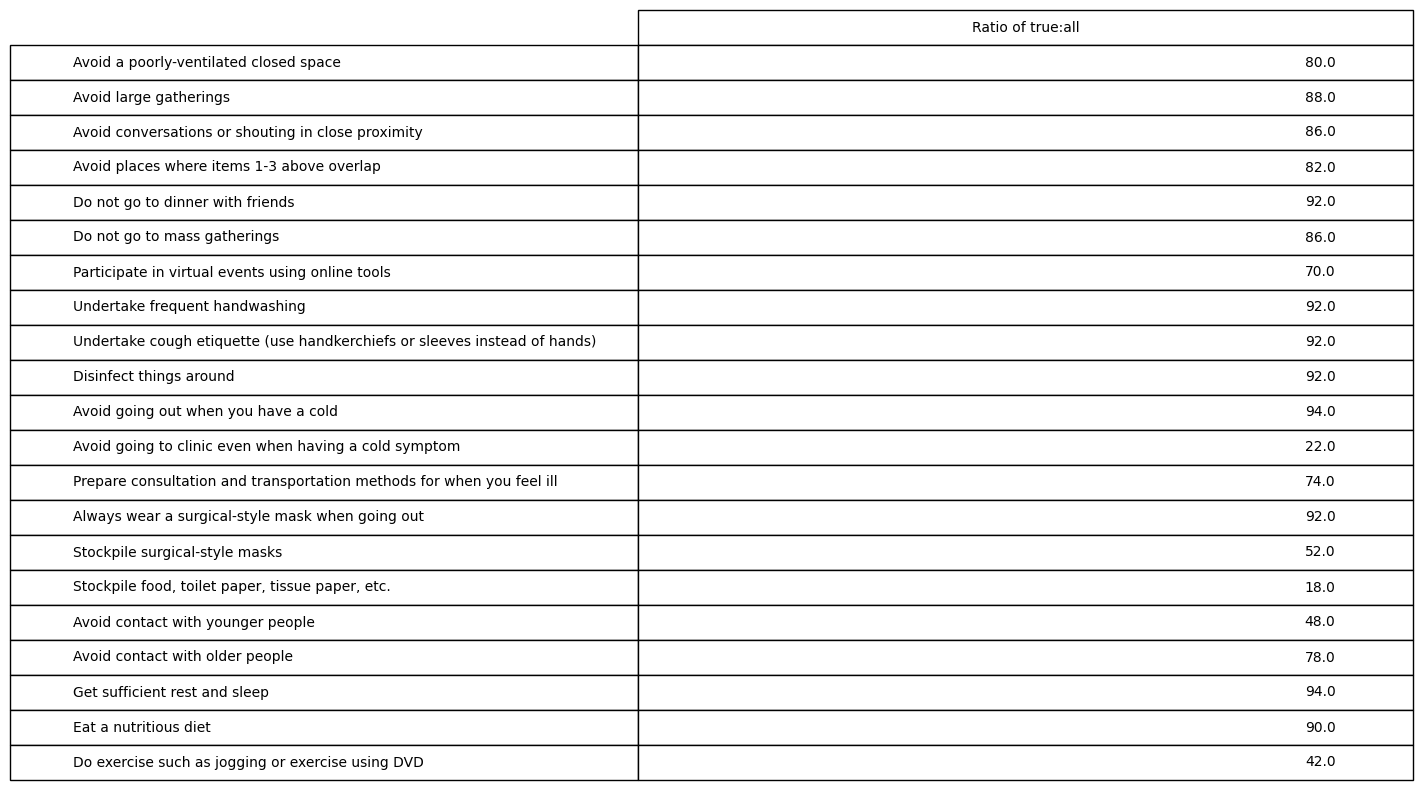

"\n# Additional analysis\ndf_dummies = create_dummies(df_sampled_data, ['AGE', 'SEX', 'MARRIED', 'GRADUATE UNIVERSITY', 'CHILD', 'WORK', 'HOUSE INCOME'])\ndf_merged_data = pd.concat([df_sampled_data, df_dummies], axis=1)\nlist_binary_cols = df_merged_data.select_dtypes(include='uint8').columns\ndf_merged_data[list_binary_cols] = df_merged_data[list_binary_cols].astype(int)\n\nlist_odds_ratios = calculate_odds_ratio(df_merged_data)\nprint(list_odds_ratios)\n\n"

In [21]:
# Data aggregation and analysis
dict_aggregate = aggregate_data_dict(dict_sampled_responses, list_questions, list_options)
df_aggregate = pd.DataFrame.from_dict(dict_aggregate)
df_calculate = calculate_ratio(df_aggregate.T, "all")
table_plot(df_calculate, 10, 10)

"""
# Additional analysis
df_dummies = create_dummies(df_sampled_data, ['AGE', 'SEX', 'MARRIED', 'GRADUATE UNIVERSITY', 'CHILD', 'WORK', 'HOUSE INCOME'])
df_merged_data = pd.concat([df_sampled_data, df_dummies], axis=1)
list_binary_cols = df_merged_data.select_dtypes(include='uint8').columns
df_merged_data[list_binary_cols] = df_merged_data[list_binary_cols].astype(int)

list_odds_ratios = calculate_odds_ratio(df_merged_data)
print(list_odds_ratios)

"""

In [26]:
df_aggregate.head()

,Avoid a poorly-ventilated closed space,Avoid large gatherings,Avoid conversations or shouting in close proximity,Avoid places where items 1-3 above overlap,Do not go to dinner with friends,Do not go to mass gatherings,Participate in virtual events using online tools,Undertake frequent handwashing,Undertake cough etiquette (use handkerchiefs or sleeves instead of hands),Disinfect things around,...,Avoid going to clinic even when having a cold symptom,Prepare consultation and transportation methods for when you feel ill,Always wear a surgical-style mask when going out,Stockpile surgical-style masks,"Stockpile food, toilet paper, tissue paper, etc.",Avoid contact with younger people,Avoid contact with older people,Get sufficient rest and sleep,Eat a nutritious diet,Do exercise such as jogging or exercise using DVD
1.Very true,28,28,29,29,29,27,14,42,42,30,...,0,14,42,0,0,0,19,39,34,6
2.True,12,16,14,12,17,16,21,4,4,16,...,11,23,4,26,9,24,20,8,11,15
3.Neither,9,6,7,8,4,7,9,4,4,4,...,7,13,4,21,37,25,10,3,5,22
4.Not true,1,0,0,1,0,0,5,0,0,0,...,32,0,0,2,3,0,0,0,0,4
5.Not at all,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,3


In [43]:
# DataFrameを表として出力
display(df_aggregate.T.head(21))

,1.Very true,2.True,3.Neither,4.Not true,5.Not at all
Avoid a poorly-ventilated closed space,28,12,9,1,0
Avoid large gatherings,28,16,6,0,0
Avoid conversations or shouting in close proximity,29,14,7,0,0
Avoid places where items 1-3 above overlap,29,12,8,1,0
Do not go to dinner with friends,29,17,4,0,0
Do not go to mass gatherings,27,16,7,0,0
Participate in virtual events using online tools,14,21,9,5,1
Undertake frequent handwashing,42,4,4,0,0
Undertake cough etiquette (use handkerchiefs or sleeves instead of hands),42,4,4,0,0
Disinfect things around,30,16,4,0,0


In [36]:

# Age-based analysis
merged_dict = merge_dicts(dict_sampled_responses, dict_answer)
u_40_filter = [["3.0", "4.0", "5.0", "6.0"], ["7.0", "8.0", "9.0", "10.0", "11.0"]]
separated_dict = separate_data_dicts(merged_dict, u_40_filter, "AGE")
print(separated_dict[0])


dict_aggregate_u40 = aggregate_data_dict(separated_dict[0], list_questions, list_options)
print(dict_aggregate_u40)
df_aggregate_u40 = pd.DataFrame.from_dict(dict_aggregate_u40).T
df_calculate_u40 = calculate_ratio(df_aggregate_u40, "under40")

dict_aggregate_o40 = aggregate_data_dict(separated_dict[1], list_questions, list_options)
df_aggregate_o40 = pd.DataFrame.from_dict(dict_aggregate_o40).T
df_calculate_o40 = calculate_ratio(df_aggregate_o40, "over40")
display(df_calculate_o40)


{6: {'Avoid a poorly-ventilated closed space': '2.True', 'Avoid large gatherings': '2.True', 'Avoid conversations or shouting in close proximity': '2.True', 'Avoid places where items 1-3 above overlap': '2.True', 'Do not go to dinner with friends': '2.True', 'Do not go to mass gatherings': '2.True', 'Participate in virtual events using online tools': '3.Neither', 'Undertake frequent handwashing': '2.True', 'Undertake cough etiquette (use handkerchiefs or sleeves instead of hands)': '2.True', 'Disinfect things around': '2.True', 'Avoid going out when you have a cold': '2.True', 'Avoid going to clinic even when having a cold symptom': '4.Not true', 'Prepare consultation and transportation methods for when you feel ill': '3.Neither', 'Always wear a surgical-style mask when going out': '2.True', 'Stockpile surgical-style masks': '3.Neither', 'Stockpile food, toilet paper, tissue paper, etc.': '3.Neither', 'Avoid contact with younger people': '3.Neither', 'Avoid contact with older people': 

,Ratio of true:over40
Avoid a poorly-ventilated closed space,81.48
Avoid large gatherings,85.19
Avoid conversations or shouting in close proximity,85.19
Avoid places where items 1-3 above overlap,81.48
Do not go to dinner with friends,88.89
Do not go to mass gatherings,85.19
Participate in virtual events using online tools,74.07
Undertake frequent handwashing,88.89
Undertake cough etiquette (use handkerchiefs or sleeves instead of hands),88.89
Disinfect things around,88.89


In [39]:
# Age-based analysis
merged_dict = merge_dicts(dict_sampled_responses, dict_answer)
sex_filter = [["Male"], ["Female"]]
separated_dict = separate_data_dicts(merged_dict, sex_filter, "SEX")
print(separated_dict[0])


dict_aggregate_male = aggregate_data_dict(separated_dict[0], list_questions, list_options)
print(dict_aggregate_male)
df_aggregate_male = pd.DataFrame.from_dict(dict_aggregate_male).T
df_calculate_male = calculate_ratio(df_aggregate_male, "male")

dict_aggregate_female = aggregate_data_dict(separated_dict[1], list_questions, list_options)
df_aggregate_female = pd.DataFrame.from_dict(dict_aggregate_female).T
df_calculate_female = calculate_ratio(df_aggregate_female, "female")
display(df_calculate_female)

{1: {'Avoid a poorly-ventilated closed space': '3.Neither', 'Avoid large gatherings': '3.Neither', 'Avoid conversations or shouting in close proximity': '3.Neither', 'Avoid places where items 1-3 above overlap': '3.Neither', 'Do not go to dinner with friends': '3.Neither', 'Do not go to mass gatherings': '3.Neither', 'Participate in virtual events using online tools': '3.Neither', 'Undertake frequent handwashing': '3.Neither', 'Undertake cough etiquette (use handkerchiefs or sleeves instead of hands)': '3.Neither', 'Disinfect things around': '3.Neither', 'Avoid going out when you have a cold': '3.Neither', 'Avoid going to clinic even when having a cold symptom': '3.Neither', 'Prepare consultation and transportation methods for when you feel ill': '3.Neither', 'Always wear a surgical-style mask when going out': '3.Neither', 'Stockpile surgical-style masks': '3.Neither', 'Stockpile food, toilet paper, tissue paper, etc.': '3.Neither', 'Avoid contact with younger people': '3.Neither', 'Av

,Ratio of true:female
Avoid a poorly-ventilated closed space,83.33
Avoid large gatherings,93.33
Avoid conversations or shouting in close proximity,86.67
Avoid places where items 1-3 above overlap,86.67
Do not go to dinner with friends,93.33
Do not go to mass gatherings,90.00
Participate in virtual events using online tools,66.67
Undertake frequent handwashing,93.33
Undertake cough etiquette (use handkerchiefs or sleeves instead of hands),93.33
Disinfect things around,93.33


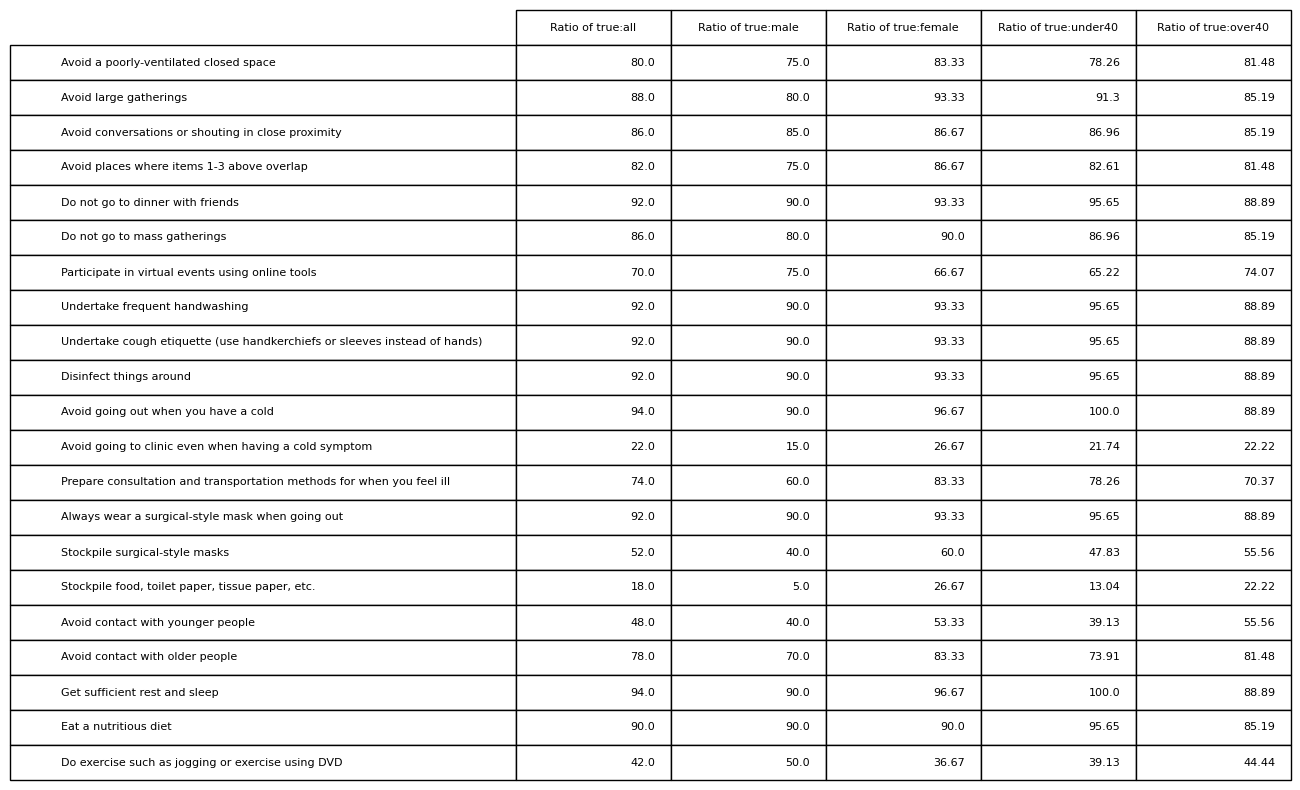

In [40]:
#merge data frames
df_calculate_merged = pd.concat([df_calculate,df_calculate_male,df_calculate_female,df_calculate_u40, df_calculate_o40], axis=1)
table_plot(df_calculate_merged, 10, 10)

In [ ]:

# OpenAI-based response generation
df_sampled_responses, dict_sampled_responses = get_response_dict(dict_answer)

# Additional analysis
df_dummies = create_dummies(df_sampled_data, ['AGE', 'SEX', 'MARRIED', 'GRADUATE UNIVERSITY', 'CHILD', 'WORK', 'HOUSE INCOME'])
df_merged_data = pd.concat([df_sampled_data, df_dummies], axis=1)
list_binary_cols = df_merged_data.select_dtypes(include='uint8').columns
df_merged_data[list_binary_cols] = df_merged_data[list_binary_cols].astype(int)

list_odds_ratios = calculate_odds_ratio(df_merged_data)
print(list_odds_ratios)
